# 05-FunnelAnalysis

Investigate whether there is something wrong in the conversion funnel or, in general, if you could suggest how conversion rate can be improved for the web.

Specifically, in :
* A full picture of funnel conversion rate for both desktop and mobile
* Some insights on what the product team should focus on in order to improve conversion rate as well as anything you might discover that could help improve

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import graphviz

## Load datasets

In [6]:
user_table = pd.read_csv('./datasets/05-FunnelAnalysis/user_table.csv')
home_page_table = pd.read_csv('./datasets/05-FunnelAnalysis/home_page_table.csv')
search_page_table = pd.read_csv('./datasets/05-FunnelAnalysis/search_page_table.csv')
payment_page_table = pd.read_csv('./datasets/05-FunnelAnalysis/payment_page_table.csv')
payment_confirmation_table = pd.read_csv('./datasets/05-FunnelAnalysis/payment_confirmation_table.csv')

In [7]:
user_table.head()

,user_id,date,device,sex
0,450007,2015-02-28,Desktop,Female
1,756838,2015-01-13,Desktop,Male
2,568983,2015-04-09,Desktop,Male
3,190794,2015-02-18,Desktop,Female
4,537909,2015-01-15,Desktop,Male


In [11]:
payment_confirmation_table.head()

,user_id,page
0,123100,payment_confirmation_page
1,704999,payment_confirmation_page
2,407188,payment_confirmation_page
3,538348,payment_confirmation_page
4,841681,payment_confirmation_page


## Data processing

In [12]:
data = pd.merge(left=user_table, right=home_page_table, how='left', on='user_id')
data = pd.merge(left=data, right=search_page_table, how='left', on='user_id', suffixes=('_home', '_search'))
data = pd.merge(left=data, right=payment_page_table, how='left', on='user_id')
data = pd.merge(left=data, right=payment_confirmation_table, how='left', on='user_id', suffixes=('_payment', '_confirmation'))
data.head()

,user_id,date,device,sex,page_home,page_search,page_payment,page_confirmation
0,450007,2015-02-28,Desktop,Female,home_page,NaN,NaN,NaN
1,756838,2015-01-13,Desktop,Male,home_page,NaN,NaN,NaN
2,568983,2015-04-09,Desktop,Male,home_page,search_page,NaN,NaN
3,190794,2015-02-18,Desktop,Female,home_page,search_page,NaN,NaN
4,537909,2015-01-15,Desktop,Male,home_page,NaN,NaN,NaN


In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90400 entries, 0 to 90399
Data columns (total 8 columns):
user_id              90400 non-null int64
date                 90400 non-null object
device               90400 non-null object
sex                  90400 non-null object
page_home            90400 non-null object
page_search          45200 non-null object
page_payment         6030 non-null object
page_confirmation    452 non-null object
dtypes: int64(1), object(7)
memory usage: 8.7+ MB


## Data analysis

### 1. Visit Probability for Each Page

In [20]:
conv_ratio = 1 - pd.DataFrame(data.isnull().sum()).rename(columns={0: 'conversion'}) / len(data)
conv_ratio = conv_ratio.reset_index()[4:]
conv_ratio

,index,conversion
4,page_home,1.000000
5,page_search,0.500000
6,page_payment,0.066704
7,page_confirmation,0.005000


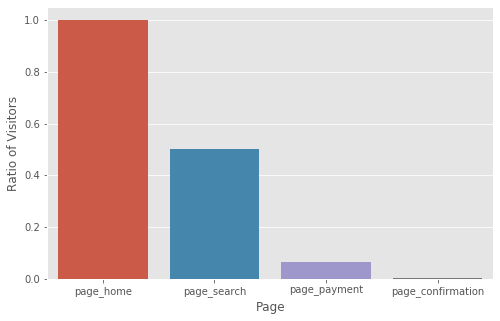

In [21]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.barplot(x='index', y='conversion', data=conv_ratio, ax=ax)
ax.set_xlabel('Page', fontsize=12)
ax.set_ylabel('Ratio of Visitors', fontsize=12)
plt.show()

## 2. Conversion Rate for Each Page

In [23]:
def conversion_rate(df):
    """ function to calculate conversion rates for home, search and payment page"""
    rates = []
    tmp = df[~df['page_home'].isnull()]
    rates.append(1 - tmp['page_search'].isnull().sum() / len(tmp))
    
    tmp = df[~df['page_search'].isnull()]
    rates.append(1 - tmp['page_payment'].isnull().sum() / len(tmp))
    
    tmp = df[~df['page_payment'].isnull()]
    rates.append(1 - tmp['page_confirmation'].isnull().sum() / len(tmp))
    
    return rates

### 1) Overall

In [25]:
rates = conversion_rate(data)
names = ['home', 'search', 'payment']
maps = {'Page': ['home', 'search', 'payment'], 'Conversion Rate': rates}
overall_conv = pd.DataFrame(maps, columns=['Page', 'Conversion Rate'])

overall_conv

,Page,Conversion Rate
0,home,0.500000
1,search,0.133407
2,payment,0.074959


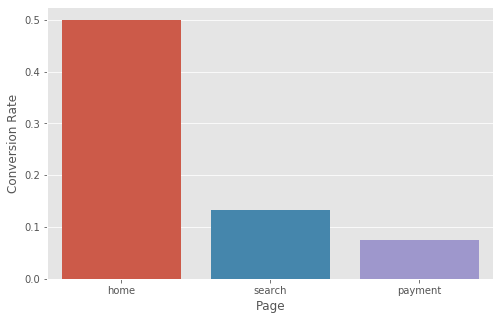

In [26]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.barplot(x='Page', y='Conversion Rate', data=overall_conv, ax=ax)
plt.show()

### 2) Device

In [27]:
print(data['device'].unique())

['Desktop' 'Mobile']


In [28]:
desk_rates = conversion_rate(data[data['device'] == 'Desktop'])
mobile_rates = conversion_rate(data[data['device'] == 'Mobile'])
names = ['home', 'search', 'payment']
print('{0:^10s} | {1:^10s} | {2:^10s}'.format('Page', 'Desktop', 'Mobile'))
print('-' * 40)
for name, desk_rate, mobile_rate in zip(names, desk_rates, mobile_rates):
    print('{0:10s} | {1:10.6f} | {2:10.6f}'.format(name, desk_rate, mobile_rate))

   Page    |  Desktop   |   Mobile  
----------------------------------------
home       |   0.500000 |   0.500000
search     |   0.100000 |   0.200000
payment    |   0.049834 |   0.100000


In [31]:
# Visualization
maps = {'Page': ['home', 'search', 'payment', 'home', 'search', 'payment'], 
        'Device': ['Desktop', 'Desktop', 'Desktop', 'Mobile', 'Mobile', 'Mobile'], 
        'Conversion Rate': desk_rates + mobile_rates}
device_conv = pd.DataFrame(maps, columns=['Page', 'Device', 'Conversion Rate'])
device_conv

,Page,Device,Conversion Rate
0,home,Desktop,0.500000
1,search,Desktop,0.100000
2,payment,Desktop,0.049834
3,home,Mobile,0.500000
4,search,Mobile,0.200000
5,payment,Mobile,0.100000


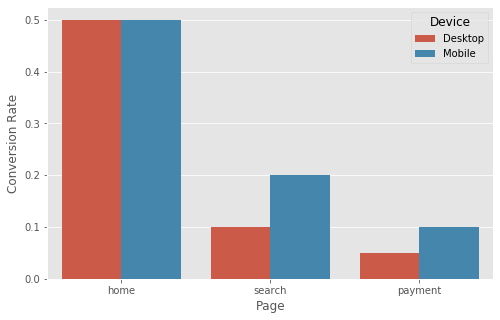

In [32]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.barplot(x='Page', y='Conversion Rate', data=device_conv, ax=ax, hue='Device')
plt.show()

### 3) Sex

In [33]:
print(data['sex'].unique())

['Female' 'Male']


In [34]:
male_rates = conversion_rate(data[data['sex'] == 'Male'])
female_rates = conversion_rate(data[data['sex'] == 'Female'])
names = ['home', 'search', 'payment']
print('{0:^10s} | {1:^10s} | {2:^10s}'.format('Page', 'Male', 'Female'))
print('-' * 40)
for name, male_rate, female_rate in zip(names, male_rates, female_rates):
    print('{0:10s} | {1:10.6f} | {2:10.6f}'.format(name, male_rate, female_rate))

   Page    |    Male    |   Female  
----------------------------------------
home       |   0.496944 |   0.503073
search     |   0.130083 |   0.136708
payment    |   0.072014 |   0.077742


In [36]:
# Visualization
maps = {'Page': ['home', 'search', 'payment', 'home', 'search', 'payment'], 
        'Sex': ['Male', 'Male', 'Male', 'Female', 'Female', 'Female'], 
        'Conversion Rate': male_rates + female_rates}
sex_conv = pd.DataFrame(maps, columns=['Page', 'Sex', 'Conversion Rate'])
sex_conv

,Page,Sex,Conversion Rate
0,home,Male,0.496944
1,search,Male,0.130083
2,payment,Male,0.072014
3,home,Female,0.503073
4,search,Female,0.136708
5,payment,Female,0.077742


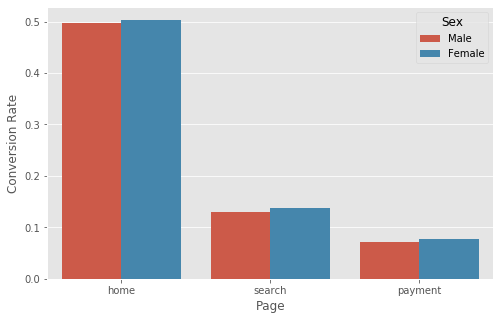

In [37]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.barplot(x='Page', y='Conversion Rate', data=sex_conv, ax=ax, hue='Sex')
plt.show()

**Conclusions:**
1. Needs to improve the conversion rate from home to search
2. Mobile users have a higher conversion rate compared with the desktop users
3. Female users have a slightly higher conversion rate compared with male users

**References:**
1. https://github.com/JifuZhao/DS-Take-Home/blob/master/05.%20Funnel%20Analysis.ipynb